# User Wise Hybrid

In [1]:
from Utils.Toolkit import get_data

data = get_data()

URM = data['train'].tocsr()
ICM = data['ICM_subclass'].tocsr()

## Let's divide users intro groups

In [2]:
import numpy as np

group0 = []
group1 = []
group2 = []
group3 = []
group4 = []
group5 = []
group6 = []
group7 = []
group8 = []
group9 = []

for user_id in range(URM.shape[0]):
    start_pos = URM.indptr[user_id]
    end_pos = URM.indptr[user_id + 1]
    if len(URM.data[start_pos:end_pos]) == 0:
        group0.append(user_id)
    elif 0 < len(URM.data[start_pos:end_pos]) <= 2:
        group1.append(user_id)
    elif 2 < len(URM.data[start_pos:end_pos]) <= 5:
        group2.append(user_id)
    elif 5 < len(URM.data[start_pos:end_pos]) <= 10:
        group3.append(user_id)
    elif 10 < len(URM.data[start_pos:end_pos]) <= 20:
        group4.append(user_id)
    elif 20 < len(URM.data[start_pos:end_pos]) <= 30:
        group5.append(user_id)
    elif 40 < len(URM.data[start_pos:end_pos]) <= 60:
        group6.append(user_id)
    elif 60 < len(URM.data[start_pos:end_pos]) <= 100:
        group7.append(user_id)
    elif 100 < len(URM.data[start_pos:end_pos]) <= 300:
        group8.append(user_id)
    elif 300 < len(URM.data[start_pos:end_pos]) <= 10000:
        group9.append(user_id)

        
group0 = np.array(group0)
group1 = np.array(group1)
group2 = np.array(group2)
group3 = np.array(group3)
group4 = np.array(group4)
group5 = np.array(group5)
group6 = np.array(group6)
group7 = np.array(group7)
group8 = np.array(group8)
group9 = np.array(group9)

group = np.array([group0, group1, group2, group3, group4, group5, group6, group7, group8, group9])

In [3]:
print(str(len(group0)) + " Cold users")
print(len(group1))
print(len(group2))
print(len(group3))
print(len(group4))
print(len(group5))
print(len(group6))
print(len(group7))
print(len(group8))
print(len(group9))

6473 Cold users
3695
4556
5034
5443
2502
1183
530
131
5


In [16]:
from Recommenders.HYB.hybrid import HybridRecommender

userCF_args = {
        'topK' : 102,
        'shrink' : 7
}

userCBF_args = {
    'topK' : 1000,
    'shrink' : 7950
}

itemCF_args = {
    'topK' : 29,
    'shrink' : 5
}
itemCBF_args = {
    'topK' : 29,
    'shrink' : 5
}

SLIM_BPR_args = {
    'topK': 20,
    'lambda_i': 5.0,
    'lambda_j': 7.0,
    'epochs': 5000,
    'learning_rate' : 1e-4,
    'symmetric' : True,
    'sgd_mode' : 'adam'
}

weights = {
    'user_cf' : 0,
    'item_cf' : 1.55,
    'SLIM_BPR' : 1.72,
    'item_cbf' : 0,
    'ALS' : 0.75
}

hyb = HybridRecommender(weights=weights,
                            userCF_args=userCF_args,
                            SLIM_BPR_args=SLIM_BPR_args,
                            itemCF_args=itemCF_args,
                            itemCBF_args=itemCBF_args,
                            userCBF_args=userCBF_args)

hyb.fit(URM, ICM, data['UCM'].tocsr())

Fitting ItemCF...
Fitting UserCBF...
Fitting SLIM...
Fitting ALS...



Done fitting models...


In [11]:
from Recommenders.CF.FeatureBoostedItemCollaborative import FeatureBoostedItemCollaborativeFiltering
from Recommenders.CF.item_cf import ItemBasedCollaborativeFiltering
from Recommenders.CF.user_cf import UserBasedCollaborativeFiltering
from Recommenders.CBF.user_CBF import UserContentBasedRecommender
from Recommenders.CBF.item_CBF import ItemContentBasedRecommender
from Recommenders.SLIM.SLIM_BPR_Cython import SLIM_BPR_Cython

itemCF = ItemBasedCollaborativeFiltering(29, 5)
itemCF.fit(URM.copy())

userCBF = UserContentBasedRecommender(1000, 7900)
userCBF.fit(URM.copy(), data['UCM'])

userCF = UserBasedCollaborativeFiltering(94, 19)
userCF.fit(URM.copy())

itemCBF = ItemContentBasedRecommender(100, 5)
itemCBF.fit(URM.copy(), ICM)



slim = SLIM_BPR_Cython(epochs=5000,
                               topK=20,
                               lambda_i=1.0,
                               lambda_j=7.0,
                               positive_threshold=1,
                               sgd_mode="adam",
                               symmetric=False,
                               learning_rate=1e-4)

slim.fit(URM.copy())

In [17]:
MAPs_ICF = []
MAPs_UCBF = []
MAPs_ICBF = []
MAPs_UCF = []
MAPs_slim = []
MAPs_hyb = []

for group_id in range(len(group)):
    
    result = itemCF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_ICF.append(result['MAP'])
    
    result = userCBF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_UCBF.append(result['MAP'])
    
    result = itemCBF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_ICBF.append(result['MAP'])
    
    result = userCF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_UCF.append(result['MAP'])
    
    result = slim.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_slim.append(result['MAP'])
    
    result = hyb.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_hyb.append(result['MAP'])

Evaluating MAP with target:   4%|▍         | 261/6473 [00:00<00:05, 1233.41it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   4%|▍         | 286/6473 [00:00<00:02, 2844.58it/s]

UserContentBasedRecommender -> MAP: 0.0014	TOTAL MISS=2696	Relevant=121


Evaluating MAP with target:   5%|▍         | 305/6473 [00:00<00:02, 3036.67it/s]

ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   5%|▌         | 346/6473 [00:00<00:01, 3446.52it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   2%|▏         | 113/6473 [00:00<00:05, 1110.07it/s]

BaseRecommender -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   3%|▎         | 122/3695 [00:00<00:02, 1218.62it/s]

HYB -> MAP: 0.0014	TOTAL MISS=2696	Relevant=121


Evaluating MAP with target:   2%|▏         | 74/3695 [00:00<00:04, 732.81it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0067	TOTAL MISS=3388	Relevant=307


Evaluating MAP with target:   4%|▎         | 138/3695 [00:00<00:02, 1373.75it/s]

UserContentBasedRecommender -> MAP: 0.0011	TOTAL MISS=3584	Relevant=111


Evaluating MAP with target:   3%|▎         | 110/3695 [00:00<00:03, 1099.96it/s]

ItemContentBasedRecommender -> MAP: 0.0006	TOTAL MISS=3644	Relevant=51


Evaluating MAP with target:   4%|▍         | 141/3695 [00:00<00:02, 1406.13it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0067	TOTAL MISS=3336	Relevant=359


Evaluating MAP with target:   2%|▏         | 82/3695 [00:00<00:09, 401.34it/s]

BaseRecommender -> MAP: 0.0065	TOTAL MISS=3386	Relevant=309


Evaluating MAP with target:   5%|▍         | 226/4556 [00:00<00:03, 1106.67it/s]

HYB -> MAP: 0.0074	TOTAL MISS=3310	Relevant=385


Evaluating MAP with target:   2%|▏         | 70/4556 [00:00<00:06, 691.39it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0101	TOTAL MISS=4039	Relevant=517


Evaluating MAP with target:   6%|▌         | 268/4556 [00:00<00:03, 1337.68it/s]

UserContentBasedRecommender -> MAP: 0.0015	TOTAL MISS=4416	Relevant=140


Evaluating MAP with target:   4%|▍         | 174/4556 [00:00<00:05, 865.54it/s]

ItemContentBasedRecommender -> MAP: 0.0010	TOTAL MISS=4470	Relevant=86


Evaluating MAP with target:   3%|▎         | 115/4556 [00:00<00:03, 1145.32it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0067	TOTAL MISS=4178	Relevant=378


Evaluating MAP with target:   1%|          | 30/4556 [00:00<00:15, 299.02it/s]

BaseRecommender -> MAP: 0.0085	TOTAL MISS=4111	Relevant=445


Evaluating MAP with target:   2%|▏         | 100/5034 [00:00<00:04, 997.15it/s]

HYB -> MAP: 0.0101	TOTAL MISS=4016	Relevant=540


Evaluating MAP with target:   1%|▏         | 63/5034 [00:00<00:07, 629.91it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0097	TOTAL MISS=4459	Relevant=575


Evaluating MAP with target:   2%|▏         | 107/5034 [00:00<00:04, 1063.12it/s]

UserContentBasedRecommender -> MAP: 0.0012	TOTAL MISS=4897	Relevant=137


Evaluating MAP with target:   2%|▏         | 110/5034 [00:00<00:04, 1096.22it/s]

ItemContentBasedRecommender -> MAP: 0.0009	TOTAL MISS=4970	Relevant=64


Evaluating MAP with target:   3%|▎         | 130/5034 [00:00<00:03, 1296.50it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0044	TOTAL MISS=4751	Relevant=283


Evaluating MAP with target:   1%|          | 40/5034 [00:00<00:12, 392.56it/s]

BaseRecommender -> MAP: 0.0081	TOTAL MISS=4549	Relevant=485


Evaluating MAP with target:   1%|▏         | 72/5443 [00:00<00:07, 719.89it/s]

HYB -> MAP: 0.0097	TOTAL MISS=4432	Relevant=602


Evaluating MAP with target:   1%|          | 66/5443 [00:00<00:08, 651.85it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0093	TOTAL MISS=4853	Relevant=590


Evaluating MAP with target:   2%|▏         | 108/5443 [00:00<00:04, 1076.63it/s]

UserContentBasedRecommender -> MAP: 0.0018	TOTAL MISS=5287	Relevant=156


Evaluating MAP with target:   2%|▏         | 102/5443 [00:00<00:05, 1016.32it/s]

ItemContentBasedRecommender -> MAP: 0.0008	TOTAL MISS=5380	Relevant=63


Evaluating MAP with target:   2%|▏         | 110/5443 [00:00<00:04, 1098.11it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0031	TOTAL MISS=5259	Relevant=184


Evaluating MAP with target:   1%|          | 38/5443 [00:00<00:14, 376.43it/s]

BaseRecommender -> MAP: 0.0077	TOTAL MISS=4951	Relevant=492


Evaluating MAP with target:   8%|▊         | 189/2502 [00:00<00:02, 937.68it/s]

HYB -> MAP: 0.0091	TOTAL MISS=4883	Relevant=560


Evaluating MAP with target:   3%|▎         | 65/2502 [00:00<00:03, 649.33it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0033	TOTAL MISS=2274	Relevant=228


Evaluating MAP with target:   4%|▍         | 103/2502 [00:00<00:02, 1023.42it/s]

UserContentBasedRecommender -> MAP: 0.0008	TOTAL MISS=2437	Relevant=65


Evaluating MAP with target:   4%|▍         | 98/2502 [00:00<00:02, 977.04it/s]

ItemContentBasedRecommender -> MAP: 0.0002	TOTAL MISS=2481	Relevant=21


Evaluating MAP with target:   4%|▍         | 104/2502 [00:00<00:02, 1032.91it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0005	TOTAL MISS=2463	Relevant=39


Evaluating MAP with target:   2%|▏         | 38/2502 [00:00<00:06, 371.42it/s]

BaseRecommender -> MAP: 0.0027	TOTAL MISS=2307	Relevant=195


Evaluating MAP with target:  12%|█▏        | 144/1183 [00:00<00:01, 710.82it/s]

HYB -> MAP: 0.0032	TOTAL MISS=2280	Relevant=222


Evaluating MAP with target:   4%|▍         | 45/1183 [00:00<00:02, 449.38it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0012	TOTAL MISS=1085	Relevant=98


Evaluating MAP with target:   7%|▋         | 79/1183 [00:00<00:01, 787.93it/s]

UserContentBasedRecommender -> MAP: 0.0002	TOTAL MISS=1160	Relevant=23


Evaluating MAP with target:  13%|█▎        | 155/1183 [00:00<00:01, 771.77it/s]

ItemContentBasedRecommender -> MAP: 0.0001	TOTAL MISS=1175	Relevant=8


Evaluating MAP with target:   6%|▌         | 71/1183 [00:00<00:01, 704.84it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0001	TOTAL MISS=1169	Relevant=14


Evaluating MAP with target:   3%|▎         | 38/1183 [00:00<00:03, 373.01it/s]

BaseRecommender -> MAP: 0.0009	TOTAL MISS=1107	Relevant=76


Evaluating MAP with target:  13%|█▎        | 70/530 [00:00<00:00, 690.53it/s]

HYB -> MAP: 0.0011	TOTAL MISS=1103	Relevant=80


Evaluating MAP with target:   8%|▊         | 45/530 [00:00<00:01, 443.75it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0004	TOTAL MISS=490	Relevant=40


Evaluating MAP with target:  14%|█▍        | 76/530 [00:00<00:00, 759.32it/s]

UserContentBasedRecommender -> MAP: 0.0001	TOTAL MISS=518	Relevant=12


Evaluating MAP with target:  29%|██▉       | 154/530 [00:00<00:00, 769.39it/s]

ItemContentBasedRecommender -> MAP: 0.0001	TOTAL MISS=524	Relevant=6


Evaluating MAP with target:  14%|█▍        | 75/530 [00:00<00:00, 747.59it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0001	TOTAL MISS=527	Relevant=3


Evaluating MAP with target:   8%|▊         | 41/530 [00:00<00:01, 401.65it/s]

BaseRecommender -> MAP: 0.0004	TOTAL MISS=502	Relevant=28


Evaluating MAP with target:   0%|          | 0/131 [00:00<?, ?it/s]

HYB -> MAP: 0.0004	TOTAL MISS=493	Relevant=37
ItemBasedCollaborativeFiltering -> MAP: 0.0002	TOTAL MISS=123	Relevant=8


Evaluating MAP with target:   0%|          | 0/131 [00:00<?, ?it/s]

UserContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=128	Relevant=3
ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=130	Relevant=1


Evaluating MAP with target:   0%|          | 0/131 [00:00<?, ?it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=130	Relevant=1
BaseRecommender -> MAP: 0.0001	TOTAL MISS=125	Relevant=6


Evaluating MAP with target: 100%|██████████| 5/5 [00:00<00:00, 329.75it/s]

HYB -> MAP: 0.0002	TOTAL MISS=123	Relevant=8
ItemBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=4	Relevant=1
UserContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=4	Relevant=1
ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
BaseRecommender -> MAP: 0.0000	TOTAL MISS=4	Relevant=1
HYB -> MAP: 0.0000	TOTAL MISS=5	Relevant=0


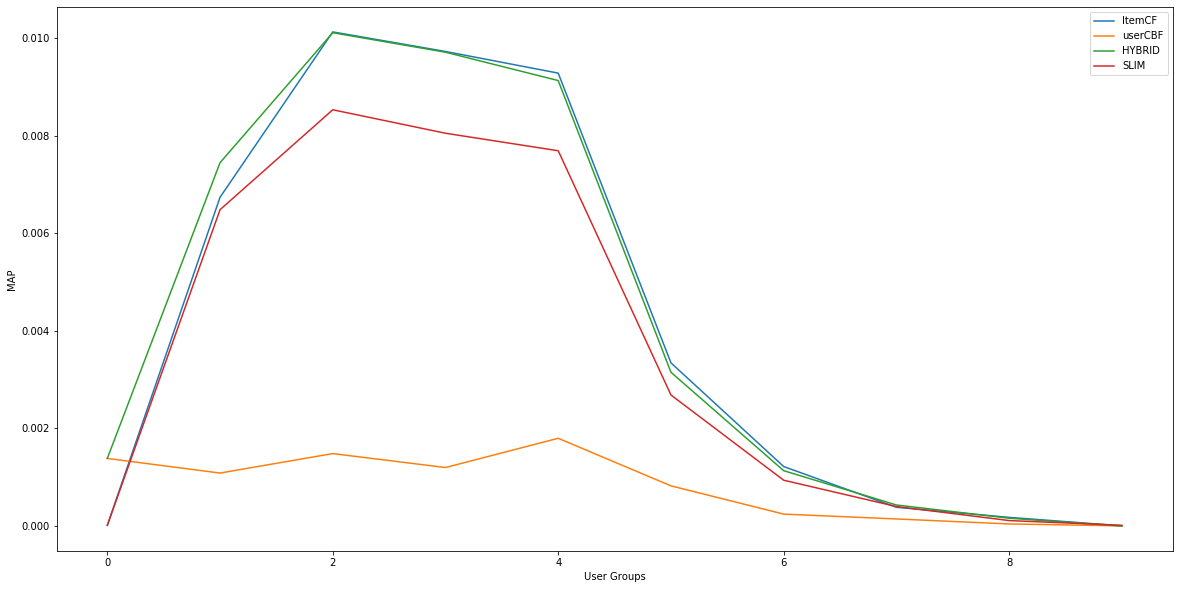

In [18]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.figure(figsize=(20,10))
pyplot.plot(MAPs_ICF, label="ItemCF")
pyplot.plot(MAPs_UCBF, label="userCBF")
pyplot.plot(MAPs_hyb, label="HYBRID")
pyplot.plot(MAPs_slim, label="SLIM")
pyplot.ylabel('MAP')
pyplot.xlabel('User Groups')
pyplot.legend()
pyplot.show()

# UserCBF tuning for cold users

In [8]:
from Utils.Toolkit import get_URM_TFIDF

MAP_topK = []
MAP_shrink = []
for shrink in [7950, 7960]:
    userCBF = UserContentBasedRecommender(10300, shrink)
    UCM = data['UCM']
    UCM = get_URM_TFIDF(UCM)
    userCBF.fit(URM.copy(), UCM)
    result = userCBF.evaluate_MAP_target(data['test'], group[0])
    MAP_topK.append(result['MAP'])

pyplot.figure(figsize=(20,10))
pyplot.plot(MAP_topK, label="UserCBF")
pyplot.ylabel('MAP')
pyplot.legend()
pyplot.show()

Evaluating MAP with target: 100%|██████████| 6473/6473 [00:03<00:00, 1714.30it/s]


UserContentBasedRecommender -> MAP: 0.0014	TOTAL MISS=2697	Relevant=120


KeyboardInterrupt: 

# ItemCBF tuning

In [ ]:
MAP_topK = []
for topK in [5, 10, 30, 50, 100, 200, 400, 700, 1000]:
    itemCBF = ItemContentBasedRecommender(topK, 5)
    itemCBF.fit(URM.copy(), ICM)
    result = userCBF.evaluate_MAP_target(data['test'], group[0])
    MAP_topK.append(result['MAP'])

pyplot.figure(figsize=(20,10))
pyplot.plot(MAP_topK, label="UserCBF")
pyplot.ylabel('MAP')
pyplot.legend()
pyplot.show()